In [1]:
import _init_paths

In [2]:
import datasets.dataset.jde as JDE
from datasets.dataset.jde import JointDataset
import torch
import torch.utils.data
from torchvision.transforms import transforms as T
from models.model import create_model, load_model, save_model
import importlib
importlib.reload(JDE)

<module 'datasets.dataset.jde' from '/workspace/Github_5AUA0_Project_G12T1/FairMOT/src/lib/datasets/dataset/jde.py'>

In [3]:
from opts import opts
import sys
sys.argv = ['/opt/conda/envs/dcnv2/lib/python3.8/site-packages/ipykernel_launcher.py', 'mot']
print(sys.argv)
sys.argv.append('--batch_size')
sys.argv.append('1')
sys.argv.append('--arch')
sys.argv.append('hrnet_18')
sys.argv.append('--load_model')
sys.argv.append('../models/model_45.pth')
sys.argv.append('--reid_dim')
sys.argv.append('256')

['/opt/conda/envs/dcnv2/lib/python3.8/site-packages/ipykernel_launcher.py', 'mot']


In [4]:
opt = opts().parse(args='')

Fix size testing.
training chunk_sizes: [0, 1]
The output will be saved to  /workspace/Github_5AUA0_Project_G12T1/FairMOT/src/lib/../../exp/mot/default


## load dataset

In [5]:
trainset_paths = {"mot17": "./data/mot17.training"}
dataset_root = '/workspace/datasets/'
transforms = T.Compose([T.ToTensor()])
dataset = JointDataset(
    opt, dataset_root, trainset_paths, (1088, 608), augment=True, transforms=transforms
)
opt = opts().update_dataset_info_and_set_heads(opt, dataset)

dataset summary
OrderedDict([('mot17', 547.0)])
total # identities: 548
start index
OrderedDict([('mot17', 0)])
heads {'hm': 1, 'wh': 2, 'id': 256, 'reg': 2}


In [6]:
  train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=opt.batch_size,
        shuffle=True,
        num_workers=opt.num_workers,
        pin_memory=True,
        drop_last=True,
    )

## load model

In [7]:
model = create_model(opt.arch, opt.heads, opt.head_conv)

{'hm': 1, 'wh': 2, 'id': 256, 'reg': 2}


In [8]:
start_epoch = 0
optimizer = torch.optim.Adam(model.parameters(), opt.lr)

    
model = load_model(model, opt.load_model)
# model = torch.nn.DataParallel(model)
model = model.to("cuda")
model.eval()
print("ok")

loaded ../models/model_45.pth, epoch 45
<class 'collections.OrderedDict'>
Skip loading parameter id.2.weight, required shapetorch.Size([256, 256, 1, 1]), loaded shapetorch.Size([128, 256, 1, 1]). If you see this, your model does not fully load the pre-trained weight. Please make sure you have correctly specified --arch xxx or set the correct --num_classes for your own dataset.
Skip loading parameter id.2.bias, required shapetorch.Size([256]), loaded shapetorch.Size([128]). If you see this, your model does not fully load the pre-trained weight. Please make sure you have correctly specified --arch xxx or set the correct --num_classes for your own dataset.
ok


## visualize model outputs and ground truth
model expects dict as input with following keys:

* input augmented image
* hm: heatmap that is generated from gaussian kernel using ground truth
* reg_mask: image prediction takes at max K objects which is zero filled, this mask either 1 or 0 depending if annotation was used at index 
* ind: integer index of image using  int(y)*w_output + int(x)
* wh: width height object
* reg:  width height offset, float(x,y) - int(x,y)
* ids: track id

In [9]:
print(opt.batch_size)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
plt.rcParams["figure.figsize"] = (10,10) #nice big plots
import numpy as np
from torchvision.transforms import ToPILImage

1


In [10]:
import math
from scipy import interpolate
import numpy as np
from torchvision.transforms import transforms as T
import torch.nn.functional as F
from models.model import create_model, load_model
from datasets.dataset.jde import JointDataset, collate_fn
from models.utils import _tranpose_and_gather_feat
from utils.utils import xywh2xyxy, ap_per_class, bbox_iou
from opts import opts
from models.decode import mot_decode
from utils.post_process import ctdet_post_process
from utils.image import gaussian_radius

In [11]:
def indtoxy(ind, ratio=4, input_w=1088, input_h=608):
    if ind != 0:
        w_out, h_out = divmod(ind,input_w//ratio)
        #print(f"out: ({w_out},{h_out})")
        return w_out*ratio, h_out*ratio
    else:
        return None

In [12]:
def wh_decode(wh_tensor, ratio=4):
    wh_numpy = wh_tensor.cpu().numpy()
    wh_numpy_decode = np.rint(ratio*wh_numpy)
    return wh_numpy_decode[0], wh_numpy_decode[1]

In [13]:
def get_pairwise_samples_positives(inputs, output_id, batch, emb_scale):

    print("iD_head", id_head.shape)
    print("output_id", output_id.shape)

    
    # negatives
    neg_distance = []
    # sample negatives per image in the batch (s_ means single, from single image)
    for b in range(id_head_all.shape[0]):
        s_id_head = id_head_all[b] # embeddings for one image in the batch
        s_anchor_embeddings = s_id_head[batch['reg_mask'][b] > 0].contiguous() # remove embeddings without GT location
        s_anchor_embeddings = emb_scale * F.normalize(s_anchor_embeddings) # normalize
        s_n = s_anchor_embeddings.size(0) # number of anchors in this image
        if self.sampling == 'random': # random negatives sampling
            for i in range(s_n): # For each anchor embedding in the image:
                # Select one random other GT object center embedding (a negative)
                N = list(range(0,s_n))
                N.remove(i) # Make sure negative is not the anchor
                m = random.choice(N)
                # Calculate distances between anchor and negative embeddings (Euclidean distance)
                neg_distance.append(torch.dist(s_anchor_embeddings[i], s_anchor_embeddings[m], p=2).unsqueeze(0))
              
        else: # hardest negatives sampling
            s_neg_distance = float('inf')*torch.ones(s_n, device=s_anchor_embeddings.device) # Set large distance
            for i in range(s_n): # For each anchor embedding in the image:
                N = list(range(0,s_n))
                N.remove(i)
                for k in N: # For all the negatives
                    # Calculate distances between anchor and negative embeddings (Euclidean distance)
                    neg_distance_next = torch.dist(s_anchor_embeddings[i], s_anchor_embeddings[k], p=2)
                    if neg_distance_next < s_neg_distance[i]: # Store the smallest distance = hardest negative
                        s_neg_distance[i] = neg_distance_next
            neg_distance.append(s_neg_distance)
    neg_distance = torch.cat(neg_distance) # list to tensor
    
    # positives sampling
    if True:
        anchor_embeddings = id_head_all[batch['reg_mask'] > 0].contiguous() # remove embeddings without GT location
        anchor_embeddings = emb_scale * F.normalize(anchor_embeddings) # normalize
        n = anchor_embeddings.size(0) # get total number of anchors

        pos_indj = torch.zeros_like(batch['ind'])
        for j in range(batch['reg_mask'].shape[0]):
            pos_ind = []
            for i in range(batch['reg_mask'].shape[1]):
                if batch['reg_mask'][j,i].cpu().numpy():
                    # get x,y
                    emb_w = output_id.shape[3] # width of the embeddings map
                    emb_h = output_id.shape[2] # height of the embeddings map
                    y, x = divmod(batch['ind'][j,i].cpu().numpy(), emb_w) # extract x and y coordinate of anchor
                    # get radius
                    w, h = wh_decode(batch['wh'][j,i])
                    radius = gaussian_radius((math.ceil(h), math.ceil(w)))
                    radius = max(0, int(radius))
                    # shift x,y with fraction of the radius
                    rad_frac = 0.5 # fraction radius distance from centerpoint
                    rnd = np.random.randint(2, size=2) # random left, right, up or down
                    if rnd[0]:
                        pos_x = x
                        if rnd[1]:
                            pos_y = min(emb_h-1, y + math.floor(rad_frac*radius))
                        else:
                            pos_y = max(0, y - math.floor(rad_frac*radius))
                    else:
                        pos_y = y
                        if rnd[1]:
                            pos_x = min(emb_w-1, x + math.floor(rad_frac*radius))
                        else:
                            pos_x = max(0, x - math.floor(rad_frac*radius))
                    # transform that to (batch['ind'] >) single number format
                    pos_ind.append(pos_y * emb_w + pos_x)
            pos_ind_t = torch.Tensor(pos_ind)
            pos_indj[j,:len(pos_ind_t)] = pos_ind_t

        # extract embedding from output feature map
        pos_embeddings = _tranpose_and_gather_feat(output_id, pos_indj)
        pos_embeddings = pos_embeddings[batch['reg_mask'] > 0].contiguous()
        pos_embeddings = emb_scale * F.normalize(pos_embeddings)
        
        if len(pos_embeddings) == n:
            pos_distance = []
            for i in range(n): # For each anchor embedding in the image:
                # Calculate distances between anchor and positive embeddings (Euclidean distance)
                pos_distance.append(torch.dist(anchor_embeddings[i], pos_embeddings[i], p=2).unsqueeze(0))
            pos_distance = torch.cat(pos_distance) # list to tensor
                    
        else:
            print('not same length')
      
        distance = torch.cat((neg_distance,pos_distance)) # concatenate negative and positive distance
          
        neg_y = -1*torch.ones_like(neg_distance) # Make tensor of -ones > negative pairs (different objects)
        pos_y = torch.ones_like(pos_distance) # Make tensor of ones > positive pair
        y = torch.cat((neg_y,pos_y)) # concatenate negative and positive y label

In [58]:
def get_pairwise_hn_positives(inputs, output_id, batch, emb_scale):
    
    id_head = _tranpose_and_gather_feat(output_id, batch['ind'].cuda()) 
    print("iD_head", id_head.shape, id_head.device)
    print("output_id", output_id.shape,output_id.device)

    id_head_all = _tranpose_and_gather_feat(output_id, batch['ind'].cuda()) 
    id_head = emb_scale * F.normalize(id_head) #  normalize 
    id_target = batch['ids'][batch['reg_mask'] > 0] # ge
    print("id_target", id_target.shape)
    print("id_head_all_shape", id_head_all.shape)
    breakpoint
    # negatives
    neg_distance = []
    
    # sample negatives per image in the batch (s_ means single, from single image)
    for b in range(id_head_all.shape[0]):
        s_id_head = id_head_all[b] # embeddings for one image in the batch
        s_anchor_embeddings = s_id_head[batch['reg_mask'][b] > 0].contiguous() # remove embeddings without GT location
        s_anchor_embeddings = emb_scale * F.normalize(s_anchor_embeddings) # normalize
        s_n = s_anchor_embeddings.size(0) # number of anchors in this image
  
        s_neg_distance = float('inf')*torch.ones(s_n, device=s_anchor_embeddings.device) # Set large distance
        for i in range(s_n): # For each anchor embedding in the image:
            N = list(range(0,s_n))
            N.remove(i)
            for k in N: # For all the negatives
                # Calculate distances between anchor and negative embeddings (Euclidean distance)
                neg_distance_next = torch.dist(s_anchor_embeddings[i], s_anchor_embeddings[k], p=2)
                if neg_distance_next < s_neg_distance[i]: # Store the smallest distance = hardest negative
                    s_neg_distance[i] = neg_distance_next
        neg_distance.append(s_neg_distance)
        
    neg_distance = torch.cat(neg_distance) # list to tensor
    
    # positives sampling
    if True:
        anchor_embeddings = id_head_all[batch['reg_mask'] > 0].contiguous() # remove embeddings without GT location
        anchor_embeddings = emb_scale * F.normalize(anchor_embeddings) # normalize
        n = anchor_embeddings.size(0) # get total number of anchors

        pos_indj = torch.zeros_like(batch['ind'])
        for j in range(batch['reg_mask'].shape[0]):
            pos_ind = []
            for i in range(batch['reg_mask'].shape[1]):
                if batch['reg_mask'][j,i].cpu().numpy():
                    # get x,y
                    emb_w = output_id.shape[3] # width of the embeddings map
                    emb_h = output_id.shape[2] # height of the embeddings map
                    y, x = divmod(batch['ind'][j,i].cpu().numpy(), emb_w) # extract x and y coordinate of anchor
                    # get radius
                    w, h = wh_decode(batch['wh'][j,i])
                    radius = gaussian_radius((math.ceil(h), math.ceil(w)))
                    radius = max(0, int(radius))
                    # shift x,y with fraction of the radius
                    rad_frac = 0.5 # fraction radius distance from centerpoint
                    rnd = np.random.randint(2, size=2) # random left, right, up or down
                    if rnd[0]:
                        pos_x = x
                        if rnd[1]:
                            pos_y = min(emb_h-1, y + math.floor(rad_frac*radius))
                        else:
                            pos_y = max(0, y - math.floor(rad_frac*radius))
                    else:
                        pos_y = y
                        if rnd[1]:
                            pos_x = min(emb_w-1, x + math.floor(rad_frac*radius))
                        else:
                            pos_x = max(0, x - math.floor(rad_frac*radius))
                    # transform that to (batch['ind'] >) single number format
                    pos_ind.append(pos_y * emb_w + pos_x)
            pos_ind_t = torch.Tensor(pos_ind)
            pos_indj[j,:len(pos_ind_t)] = pos_ind_t

        pos_ind_xy = []
        print(pos_indj.shape)
        for x in pos_indj[0]:
            ind_int = x.cpu().numpy()
            if ind_int != 0:
                #print(ind_int)
                pos_ind_xy.append(indtoxy(ind_int))
        #print(pos_ind_xy)
        
        # extract embedding from output feature map
        pos_embeddings = _tranpose_and_gather_feat(output_id, pos_indj.cuda())
        pos_embeddings = pos_embeddings[batch['reg_mask'] > 0].contiguous()
        pos_embeddings = emb_scale * F.normalize(pos_embeddings)
        
        if len(pos_embeddings) == n:
            pos_distance = []
            for i in range(n): # For each anchor embedding in the image:
                # Calculate distances between anchor and positive embeddings (Euclidean distance)
                pos_distance.append(torch.dist(anchor_embeddings[i], pos_embeddings[i], p=2).unsqueeze(0))
            pos_distance = torch.cat(pos_distance) # list to tensor
                    
        else:
            print('not same length')
      
        distance = torch.cat((neg_distance,pos_distance)) # concatenate negative and positive distance
          
        neg_y = -1*torch.ones_like(neg_distance) # Make tensor of -ones > negative pairs (different objects)
        pos_y = torch.ones_like(pos_distance) # Make tensor of ones > positive pair
        print("neg_y ", neg_y.shape)
        print("pos_y", pos_y.shape)
        y = torch.cat((neg_y,pos_y)) # concatenate negative and positive y label

    return pos_ind_xy

0
dict_keys(['input', 'hm', 'reg_mask', 'ind', 'wh', 'reg', 'ids'])
iD_head torch.Size([1, 128, 256]) cuda:0
output_id torch.Size([1, 256, 152, 272]) cuda:0
id_target torch.Size([9])
id_head_all_shape torch.Size([1, 128, 256])
torch.Size([1, 128])
neg_y  torch.Size([9])
pos_y torch.Size([9])
torch.Size([1, 1, 152, 272])


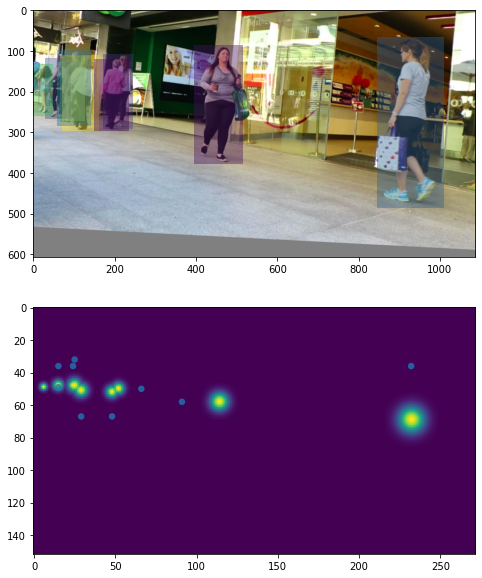

In [60]:
nID = opt.nID
emb_scale = math.sqrt(2) * math.log(nID - 1)

for iter_id, batch in enumerate(train_loader):
    print(iter_id)


    print(batch.keys())
    img_tensor = batch['input'][0,:,:,:] 
    #img  = batch['input'][0,:,:,:].cpu().numpy().reshape(608,1088,3)
    to_pil = ToPILImage()
    img_pil = to_pil(img_tensor)
    img_np =  np.array(img_pil)
    

    # do inference
    output = model(batch['input'].cuda())[-1]
    id_head = _tranpose_and_gather_feat(output['id'], batch['ind'].cuda())
    id_head = id_head[batch['reg_mask'].cuda() > 0].contiguous()
    emb_scale = math.sqrt(2) * math.log(opt.nID - 1)
    id_head = emb_scale * F.normalize(id_head)
    id_target = batch['ids'].cuda()[batch['reg_mask'].cuda() > 0]
    
    
    pos_ind_yx = get_pairwise_hn_positives(id_head, output['id'], batch, emb_scale)
    
        
    patcheslist = []
    #plot bounding boxes
    for i in range(128):
        if batch['reg_mask'][0,i].cpu().numpy():
            y,x = indtoxy(batch['ind'][0,i].cpu().numpy())
            #print(batch['wh'][0,i])
            w,h = wh_decode(batch['wh'][0,i])
            #print(batch['ind'][0,i])
            #print(indtoxy(batch['ind'][0,i].cpu().numpy()))
            #w, h = indtoxy(batch['ind'][0,i].cpu().numpy())
            #print(f"x: {x}, y: {y}")
            #print(f"w: {w}, h: {h}")
            x_plt = x - 0.5*w   # left coordinate
            y_plt = y - 0.5*h # bottom coordinate
            #print(f"x_plt: {x_plt}, y_plt: {y_plt}")
            patcheslist.append(patches.Rectangle((x_plt,y_plt),w,h,linewidth=1,edgecolor='r',facecolor='none'))
    
    patcheslist2 = []
    #plot positions of positive indexes
    for yx in pos_ind_yx:
        y,x = yx
        #print(y//4,":", x//4)
        patcheslist2.append(patches.Circle((x//4,y//4),color='r',radius=2))
        # print(yx)

    # Create figure and axes
    fig, (ax1,ax2) = plt.subplots(2)

    colors = 100*np.random.rand(len(patcheslist))
    p = PatchCollection(patcheslist, alpha=0.4)
    p.set_array(np.array(colors))
    ax1.add_collection(p)


    # Display the image
    ax1.imshow(img_np)



    print(batch['hm'].shape)
    p2 = PatchCollection(patcheslist2, alpha=0.8)
    ax2.add_collection(p2)
    ax2.imshow(batch['hm'][0,0,:,:])
    plt.show()
    break

 